In [79]:
import numpy as np
import matplotlib.pyplot as plt

# color palette
import matplotlib.colors
from matplotlib import cm

In [2]:
def design_matrix(X):
    """
    Converts a vector of shape (N, ) or a matrix of shape (N, D)
    into a design matrix of shape (N, D+1). 
    """
    # check if input X is a vector
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    nrows = X.shape[0]
    ones = np.ones((nrows, 1))
    design_matrix = np.hstack((ones, X))
    return design_matrix

## Bayesian Linear Regression

Model Assumptions:

* Gaussian distributed noise $\epsilon \sim N(0, alpha^{-1})$.
    * => Therefore targets $y_i$ are Gaussian distributed
    * => Therefore the likelihood will be a product of many Gaussians, which again is a Gaussian
* Gaussian distributed prior over the weights $w \sim N(m_0, S_0^{-1})$ where $S_0=\beta I$ is a diagonal precision matrix.

See Bishop's *Pattern Recognition and Machine Learning* pages 153 ff.

### Fitting a straight line

In [52]:
class BayesianLinearRegression:
    """
    Bayesian linear regression with assumptions:
        * normal distributed random noise epsilon ~ N(mean=0, var=alpha^{-1})
        * normal prior over weights w ~ N(vec 0, beta^{-1}*I)
    """
    # model parameters
    num_weights = None
    precision_noise = None
    precision_prior = None
    
    # model state
    prior_mean = None
    prior_cov = None
    
    def __init__(self, num_weights, precision_noise, precision_prior):
        self.num_weights = num_weights
        self.precision_noise = precision_noise 
        self.precision_prior = precision_prior 
        self._initialize_prior()
        
    def _initialize_prior(self):
        self.prior_mean = np.zeros(self.num_weights)
        self.prior_cov = (1/self.precision_prior) * np.identity(self.num_weights)
                
    def update_posterior(self, X, y):
        """
        Calculates posterior of weights p(w|D) given the likelihood of the given
        batch of data p(y|w) and the prior of the weights p(w).  
            p(w|D) ~ p(y|w) * p(w)
            
        Note that the posterior of step i becomes the prior of step i+1.
        
        This function uses analytical solutions that only apply for the
        scenario where (1) the likelihood is normal distributed, and (2) we have
        imposed a Gaussian prior over the weights.
        
        args:
            X: np.array: design matrix of shape (n_obs, num_weights) 
            y: np.array of targets y_i shaped (n_obs, )
        """
        # prior
        prior_mean = self.prior_mean
        prior_cov = self.prior_cov
        prior_cov_inv = np.linalg.inv(prior_cov)
        
        # # posterior @ zero-mean isotropic Gaussian prior (special case)
        # post_cov_inv = self.precision_prior * np.identity(self.num_weights) + \
        #     self.precision_noise * X.T.dot(X)
        # post_cov = np.linalg.inv(post_cov_inv)
        # post_mean = self.precision_noise * post_cov.dot(X.T.dot(y))
        
        # posterior @ Gaussian prior (general case)
        post_cov_inv = prior_cov_inv + self.precision_noise * X.T.dot(X)
        post_cov = np.linalg.inv(post_cov_inv)
        post_mean = post_cov.dot(prior_cov_inv.dot(prior_mean) + self.precision_noise * X.T.dot(y))
        
        # the posterior of step i becomes the posterior of step i+1
        self.prior_mean = post_mean
        self.prior_cov = post_cov
      
    def draw_weights(self, num):
        """Draw weights from posterior"""
        return np.random.multivariate_normal(
            mean=self.prior_mean,
            cov=self.prior_cov,
            size=num
        )

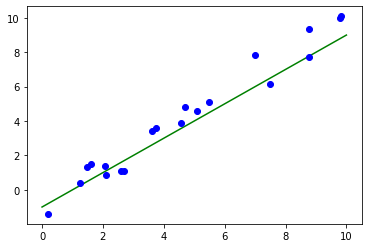

In [4]:
N = 20
w_true = [-1, 1] # underlying data-generating process
PRECISION_NOISE = 1
X_obs = design_matrix(np.random.uniform(low=0.0, high=10.0, size=N))
y_obs = X_obs.dot(w_true) + np.random.normal(loc=0.0, scale=(1/PRECISION_NOISE)**.5, size=N)

X_dgp = design_matrix(np.linspace(0, 10, 50))
y_dgp = X_dgp.dot(w_true)

plt.plot(X_dgp[:, 1], y_dgp, "g-", label="DGP")
plt.plot(X_obs[:, 1], y_obs, "bo", label="Observed")
plt.show()

In [48]:
batch_size = 6
N // batch_size # how many times does batch_size fit into N?
N % batch_size  # what is the leftover?

def create_batches(X, y, batch_size):
    """
    Creates batches from dataset. Each batch is a tuple (X, y). Batches
    are stored in a python list
    
    args:
        X: np.array shaped (n_obs, n_features)
        y: np.array shaped (n_obs, )
        batch_size: int
    
    returns:
        list of tuples (X, y) where X is shaped (batch_size, n_features)
        and y is shaped (batch_size, ). If (n_obs % batch_size) != 0, then
        the last batch will have (n_obs % batch_size) leftover observations.
    """
    n_obs = X.shape[0]
    n_batches = n_obs // batch_size + 1
    batch_size_last_batch = n_obs % batch_size
    
    batches = []
    for i in range(n_obs // batch_size):
        from_idx = i*batch_size 
        to_idx = (i+1)*batch_size
        
        X_batch_i = X[from_idx:to_idx]
        y_batch_i = y[from_idx:to_idx].reshape((-1, ))
        
        batches.append((X_batch_i, y_batch_i))
    
    if batch_size_last_batch != 0:
        X_batch_last = X[-batch_size_last_batch:]
        y_batch_last = y[-batch_size_last_batch:]
        batches.append((X_batch_last, y_batch_last))
    return batches

def generate_color_palette(size, palette="Pastel1"):
    cmap = cm.get_cmap(palette, size)
    colors = []
    for i in range(cmap.N):
        rgba = cmap(i)
        rgb = rgba[:3]
        colors.append(matplotlib.colors.rgb2hex(rgb))
    return colors

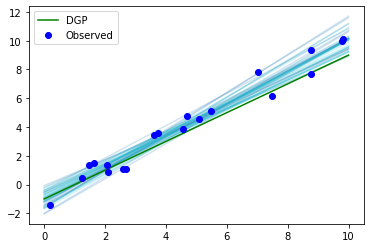

In [137]:
### initialize the model
num_weights = 2
precision_noise = 1
precision_prior = 0.5
model = BayesianLinearRegression(num_weights, precision_noise, precision_prior)

# sequential updating
batches = create_batches(X_obs, y_obs, batch_size=10)

colors = generate_color_palette(size=len(batches), palette="tab10")
color_idx = 0
for X_i, y_i in batches:
    model.update_posterior(X_i, y_i)
    weights = model.draw_weights(num=20)
    for w in weights:
        y_pred = X_dgp.dot(w)
        plt.plot(X_dgp[:, 1], y_pred, color=colors[color_idx], alpha=0.2)
    color_idx +=1
plt.plot(X_dgp[:, 1], y_dgp, "g-", label="DGP")
plt.plot(X_obs[:, 1], y_obs, "bo", label="Observed")        
plt.legend()
plt.show()

### Fitting a polynomial d=3

In [597]:
def poly_design_matrix(x, degree):
    """
    Create (N, D+1) design matrix [[1, x_i, x_i^2, x_i^3]]
    
    args:
        x: np.array
        degree: integer
    """
    N = len(x)
    X = np.empty(shape=(N, degree+1))
    for d in range(degree+1):
        X[:, d] = x**d
    return X

[ 0.05 -0.5   0.2 ]


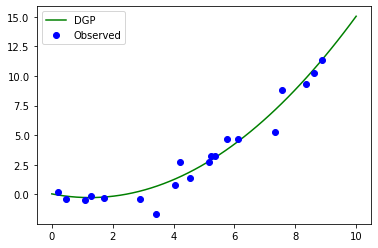

In [598]:
# can my model be extended to arbitrary polynomials?

# polynomial f(x) = w0 + w1*x + w2 * x^2 + w3 * x^3
# Create (N, D+1) design matrix [[1, x_i, x_i^2, x_i^3]]
N = 20
DEGREE = 2
NOISE_PRECISION = 1

# Data-generating process
true_w = np.array([0.05, -0.5, 0.2])
X_dgp = poly_design_matrix(np.linspace(start=0, stop=10, num=50), degree=DEGREE)
y_dgp = X_dgp.dot(true_w)

X_obs = poly_design_matrix(np.random.uniform(low=0.0, high=10.0, size=N), degree=DEGREE)
y_obs = X_obs.dot(true_w) + np.random.normal(loc=0, scale=(1/NOISE_PRECISION)**.5, size=N)

print(true_w)
plt.plot(X_dgp[:, 1], y_dgp, 'g-', label="DGP")
plt.plot(X_obs[:, 1], y_obs, 'bo', label="Observed")
plt.legend()
plt.show()

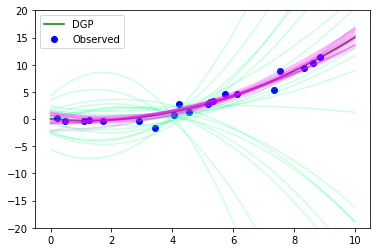

In [599]:
# initialize the model
num_weights = 3
precision_noise = 1
precision_prior = 0.2
model = BayesianLinearRegression(num_weights, precision_noise, precision_prior)

# sequential updating
# at each iteration the model takes in a single observation x_i
# and updates the posterior of the weights

plt.plot(X_dgp[:, 1], y_dgp, "g-", label="DGP")
plt.plot(X_obs[:, 1], y_obs, "bo", label="Observed")
color_idx = 0
for i in range(X_obs.shape[0]):
    x_i = X_obs[i]
    X_i = x_i.reshape((1, len(x_i)))
    y_i = y_obs[i].reshape((1, ))
    model.update_posterior(X_i, y_i)
    # w = model.draw_weights(num=1).reshape((-1, ))
    weights = model.draw_weights(num=20)
    
    colors = ["springgreen", "magenta"]
    if i % 11 == 0:
        for j, w in enumerate(weights):
            y_pred = X_dgp.dot(w)
            plt.plot(X_dgp[:, 1], y_pred, color=colors[color_idx], alpha=0.2)
        color_idx +=1
plt.ylim(-20, 20)
plt.legend()
plt.show()

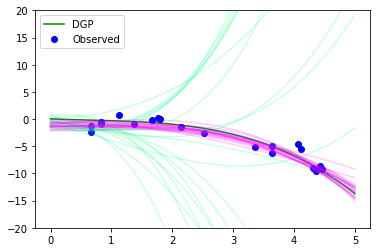

In [600]:
# Data-generating process
N = 20
DEGREE = 3
NOISE_PRECISION = 1
true_w = np.array([0.05, -0.5, 0.3, -0.15])

X_dgp = poly_design_matrix(np.linspace(start=0, stop=5, num=50), degree=DEGREE)
y_dgp = X_dgp.dot(true_w)

X_obs = poly_design_matrix(np.random.uniform(low=0.0, high=5.0, size=N), degree=DEGREE)
y_obs = X_obs.dot(true_w) + np.random.normal(loc=0, scale=(1/NOISE_PRECISION)**.5, size=N)

# initialize the model
num_weights = len(true_w)
precision_noise = 1
precision_prior = 1
model = BayesianLinearRegression(num_weights, precision_noise, precision_prior)

# sequential updating
# at each iteration the model takes in a single observation x_i
# and updates the posterior of the weights

plt.plot(X_dgp[:, 1], y_dgp, "g-", label="DGP")
plt.plot(X_obs[:, 1], y_obs, "bo", label="Observed")
color_idx = 0
for i in range(X_obs.shape[0]):
    x_i = X_obs[i]
    X_i = x_i.reshape((1, len(x_i)))
    y_i = y_obs[i].reshape((1, ))
    model.update_posterior(X_i, y_i)
    # w = model.draw_weights(num=1).reshape((-1, ))
    weights = model.draw_weights(num=20)
    
    colors = ["springgreen", "magenta"]
    if i % 11 == 0:
        for j, w in enumerate(weights):
            y_pred = X_dgp.dot(w)
            plt.plot(X_dgp[:, 1], y_pred, color=colors[color_idx], alpha=0.2)
        color_idx +=1
plt.ylim(-20, 20)
plt.legend()
plt.show()